In [1]:
def account(data, cap, fee):
    data1 = data.copy()
    data1['cash'] = cap
    data1['fee'] = np.where(data1['buyorsell'] != 0, fee, 0)
    data1['open_position'] = 0.0
    data1['traded_nominal_val'] = 0.0
    data1['unrealised_P&L'] = 0.0
    data1['cashflow'] = 0.0
    data1['total_assets'] = data1['cash'] + data1['traded_nominal_val']
    data1['net_assets'] = 0.0
    
    for i in range(1, len(data1)):
        
        if data1['buyorsell'][i] == 1:
            
            if data['pos'][i] == 1: # buy to open a long position
                
                data1['open_position'][i:] = data1['pos'][i] * ((data1['cash'][i] - data1['fee'][i]) // data1['spread_cap_req'][i])

                data1['traded_nominal_val'][i:] = data1['open_position'][i] * data1['spot_spread'][i]
                
                data1['cashflow'][i] = (-data1['traded_nominal_val'][i] - data1['fee'][i])

                data1['cash'][i:] = data1['cash'][i-1] + data1['cashflow'][i]

                data1['total_assets'][i:] = data1['cash'][i] + data1['traded_nominal_val'][i]
                
            elif data['pos'][i] == 0: # buy to close a short position
                
                data1['open_position'][i:] = data1['pos'][i]

                data1['traded_nominal_val'][i:] = data1['open_position'][i] * data1['spot_spread'][i]

                data1['cashflow'][i] = (((data1['open_position'][i-1] * data1['spot_spread'][i] ) - data1['fee'][i]) - data1['traded_nominal_val'][i-1])

                data1['cash'][i:] = data1['cash'][i-1] + data1['cashflow'][i]

                data1['total_assets'][i:] = data1['cash'][i] + data1['traded_nominal_val'][i]

        elif data1['buyorsell'][i] == -1:
            
            if data['pos'][i] == -1: # sell to open a short position
                
                data1['open_position'][i:] = data1['pos'][i] * ((data1['cash'][i] - data1['fee'][i]) // data1['spread_cap_req'][i])

                data1['traded_nominal_val'][i:] = data1['open_position'][i] * data1['spot_spread'][i]

                data1['cashflow'][i] = ( - data1['fee'][i])

                data1['cash'][i:] = data1['cash'][i-1] + data1['cashflow'][i]

                data1['total_assets'][i:] = data1['cash'][i]
                
                
            elif data['pos'][i] == 0: # sell to close a long position
                
                data1['open_position'][i:] = data1['pos'][i]
                
                data1['traded_nominal_val'][i:] = data1['open_position'][i] * data1['spot_spread'][i]
                
                data1['cashflow'][i] = ((data1['open_position'][i-1] * data1['spot_spread'][i]) - data1['fee'][i])
                
                data1['cash'][i:] = data1['cash'][i-1] + data1['cashflow'][i] - data1['traded_nominal_val'][i]
                
                data1['total_assets'][i:] = data1['cash'][i] + data1['traded_nominal_val'][i]                                                        
        
    data1['unrealised_P&L'] = (data1['open_position'] * data1['spot_spread']) - data1['traded_nominal_val']  
    data1['net_assets'] = data1['cash'] + data1['traded_nominal_val'] + data1['unrealised_P&L']
    data1['strat_acc_return_pct_chg'] = (data1['net_assets']).pct_change()
    data1['strat_acc_return_nplog_net_assets'] = (data1['net_assets'] / data1['net_assets'].shift(1)).apply(np.log)
    data1['cumsum_strat_acc'] = data1['strat_acc_return_nplog_net_assets'].cumsum().apply(np.exp)
    data1['max_performance_acc'] = data1['cumsum_strat_acc'].cummax()
    data1['drawdown_acc'] = data1['max_performance_acc'] - data1['cumsum_strat_acc']

    
    return data1

In [2]:
import numpy as np
import random
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.arima.model as stats

from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
plt.style.use('ggplot')
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['grid.color'] = 'grey'
mpl.rcParams['grid.alpha'] = 0.25

In [4]:
import warnings
warnings.filterwarnings('once')

In [5]:
from statsmodels.tsa.stattools import adfuller

In [6]:
import yfinance as yf
import pandas_datareader.data as pdr

C:\Users\lishe\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


In [7]:
def extract(tickers, s, e):
    def data(t):
        return pdr.get_data_yahoo(t, s, e)[['Close']]
    
    stock_data = map(data, tickers)
    data_con = pd.concat(stock_data, axis = 1)
    data_con.columns = tickers
    return data_con

In [8]:
stocks = ['ING', 'MS']

In [9]:
df = extract(stocks, '2020-1-1', '2022-1-1')
df.columns = stocks

C:\Users\lishe\anaconda3\lib\site-packages\pandas_datareader\data.py:80: ResourceWarning: unclosed <ssl.SSLSocket fd=4852, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.167.128.107', 51553), raddr=('106.10.236.37', 443)>
  return YahooDailyReader(*args, **kwargs).read()
C:\Users\lishe\anaconda3\lib\site-packages\pandas_datareader\data.py:80: ResourceWarning: unclosed <ssl.SSLSocket fd=4952, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.167.128.107', 51554), raddr=('106.10.236.37', 443)>
  return YahooDailyReader(*args, **kwargs).read()


In [10]:
df[df.isnull() == True].sum()

ING    0.0
MS     0.0
dtype: float64

In [11]:
df

,ING,MS
Date,,
2019-12-31,12.05,51.119999
2020-01-02,12.43,52.040001
2020-01-03,12.20,51.200001
2020-01-06,12.19,51.020000
2020-01-07,12.21,50.919998
...,...,...
2021-12-27,13.91,100.400002
2021-12-28,13.86,99.970001
2021-12-29,13.89,98.730003


In [12]:
model = sm.OLS(df[stocks[0]], sm.add_constant(df[stocks[1]])).fit()

In [13]:
model.params

const    1.719641
MS       0.125158
dtype: float64

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ING   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     3068.
Date:                Wed, 07 Dec 2022   Prob (F-statistic):          1.80e-216
Time:                        11:45:53   Log-Likelihood:                -788.70
No. Observations:                 506   AIC:                             1581.
Df Residuals:                     504   BIC:                             1590.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7196      0.166     10.374      0.000       1.394       2.045
MS             0.1252      0.002     55.392      0.000       0.121       0.130
==============================================================================
Omnibus:                      130.351   Durbin-Watson:                   0.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.136
Skew:                           1.401   Prob(JB):                     9.82e-59
Kurtosis:                       5.194   Cond. No.                         237.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
model.resid

Date
2019-12-31    3.932296
2020-01-02    4.197151
2020-01-03    4.072283
2020-01-06    4.084811
2020-01-07    4.117327
                ...   
2021-12-27   -0.375478
2021-12-28   -0.371660
2021-12-29   -0.186464
2021-12-30   -0.205226
2021-12-31   -0.085125
Length: 506, dtype: float64

In [16]:
adfuller(model.resid)

(-3.4648243475647797,
 0.008937792493588096,
 0,
 505,
 {'1%': -3.44336554668393,
  '5%': -2.867280279529963,
  '10%': -2.5698273512400744},
 -231.30698289392967)

In [17]:
df_testing = extract(stocks, '2022-1-1', '2022-10-30')
df_testing

C:\Users\lishe\anaconda3\lib\site-packages\pandas_datareader\data.py:80: ResourceWarning: unclosed <ssl.SSLSocket fd=5100, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.167.128.107', 51555), raddr=('119.161.10.12', 443)>
  return YahooDailyReader(*args, **kwargs).read()
C:\Users\lishe\anaconda3\lib\site-packages\pandas_datareader\data.py:80: ResourceWarning: unclosed <ssl.SSLSocket fd=5088, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.167.128.107', 51557), raddr=('119.161.10.12', 443)>
  return YahooDailyReader(*args, **kwargs).read()


,ING,MS
Date,,
2021-12-31,13.92,98.160004
2022-01-03,14.08,100.190002
2022-01-04,14.33,104.260002
2022-01-05,14.38,101.680000
2022-01-06,14.70,103.419998
...,...,...
2022-10-24,9.75,79.430000
2022-10-25,9.84,80.510002
2022-10-26,9.86,80.910004


In [18]:
df_testing['spot_spread'] = df_testing[stocks[0]] - model.params[1] * df_testing[stocks[1]]
df_testing['positive_2std'] = model.params[0] + (2.6 * 0.166)
df_testing['negative_2std'] = model.params[0] - (2.6 * 0.166)
df_testing['s_spread_diff'] = df_testing['spot_spread'] - model.params[0]
df_testing['s_l_p_spread'] = model.params[0] + (4 * 0.166)
df_testing['s_l_n_spread'] = model.params[0] - (4 * 0.166)
df_testing['pos'] = np.where(df_testing['spot_spread'] > df_testing['positive_2std'], -1, np.nan)
df_testing['pos'] = np.where(df_testing['spot_spread'] < df_testing['negative_2std'], 1, df_testing['pos'])
df_testing['pos'] = np.where(df_testing['spot_spread'] > df_testing['s_l_p_spread'], 0, df_testing['pos'])
df_testing['pos'] = np.where(df_testing['spot_spread'] < df_testing['s_l_n_spread'], 0, df_testing['pos'])
df_testing['pos'] = np.where((df_testing['s_spread_diff'] * df_testing['s_spread_diff'].shift(1)) < 0, 0, df_testing['pos'])
df_testing['pos'] = df_testing['pos'].ffill().fillna(0)
df_testing['buyorsell'] = df_testing['pos'].diff()
df_testing['spread_cap_req'] = df_testing[stocks[0]] + model.params[1] * df_testing[stocks[1]]


In [19]:
df_testing['buyorsell'].value_counts()

 0.0    196
 1.0      6
-1.0      6
Name: buyorsell, dtype: int64

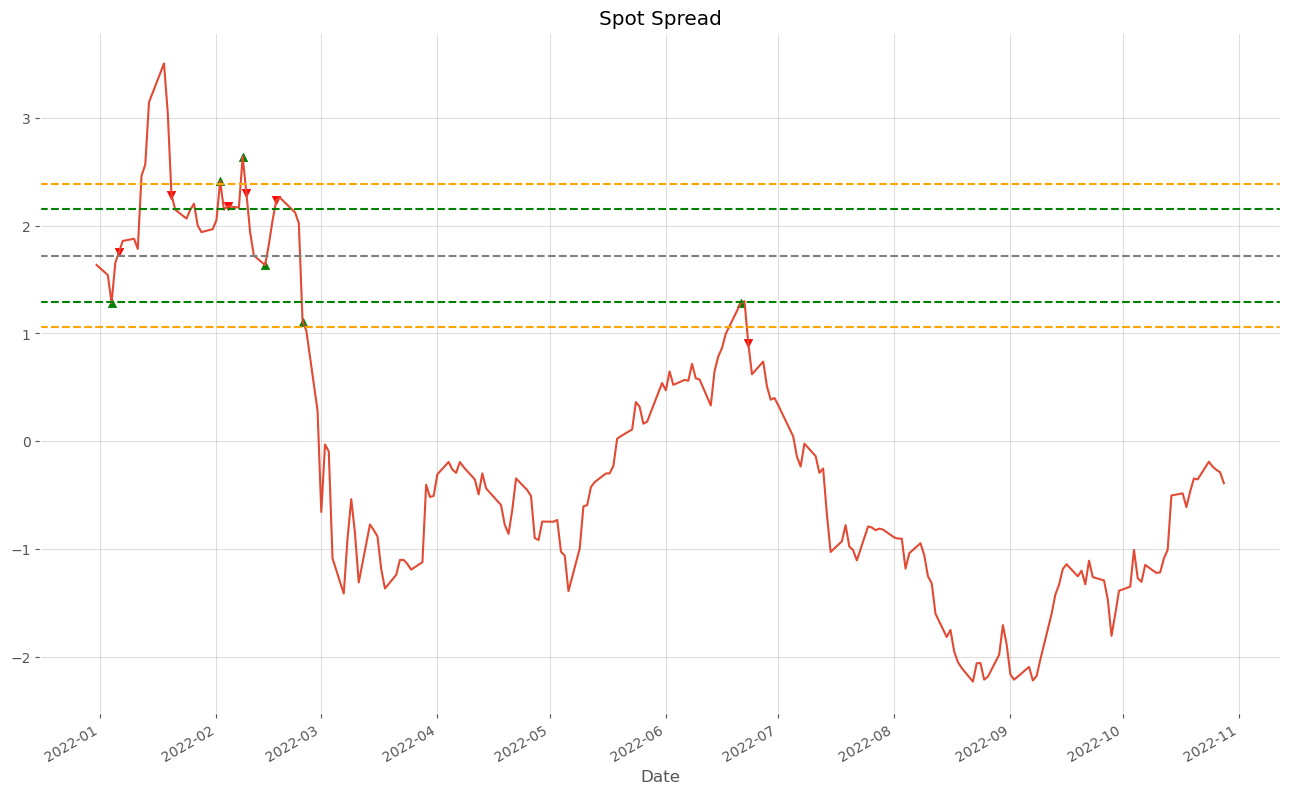

In [20]:
df_testing['spot_spread'].plot(figsize = (16,10), title = 'Spot Spread', )

plt.axhline(y = (1.719641 + (2.6 * 0.166)), color = 'green', linestyle = '--')

plt.axhline(y = 1.719641, color = 'grey', linestyle = '--')

plt.axhline(y = (1.719641 - (2.6 * 0.166)), color = 'green', linestyle = '--')

plt.axhline(y = (1.719641 + (4 * 0.166)), color = 'orange', linestyle = '--')

plt.axhline(y = (1.719641 - (4 * 0.166)), color = 'orange', linestyle = '--')

plt.scatter(x = df_testing[df_testing['buyorsell'] == 1]['spot_spread'].index,
            y = df_testing[df_testing['buyorsell'] == 1]['spot_spread'], marker = '^', color = 'green')

plt.scatter(x = df_testing[df_testing['buyorsell'] == -1]['spot_spread'].index,
            y = df_testing[df_testing['buyorsell'] == -1]['spot_spread'], marker = 'v', color = 'red')

In [21]:
df_testing.loc['2022']

,ING,MS,spot_spread,positive_2std,negative_2std,s_spread_diff,s_l_p_spread,s_l_n_spread,pos,buyorsell,spread_cap_req
Date,,,,,,,,,,,
2022-01-03,14.08,100.190002,1.540446,2.151241,1.288041,-0.179195,2.383641,1.055641,0.0,0.0,26.619554
2022-01-04,14.33,104.260002,1.281054,2.151241,1.288041,-0.438587,2.383641,1.055641,1.0,1.0,27.378946
2022-01-05,14.38,101.680000,1.653961,2.151241,1.288041,-0.065680,2.383641,1.055641,1.0,0.0,27.106039
2022-01-06,14.70,103.419998,1.756187,2.151241,1.288041,0.036546,2.383641,1.055641,0.0,-1.0,27.643813
2022-01-07,14.88,104.050003,1.857337,2.151241,1.288041,0.137696,2.383641,1.055641,0.0,0.0,27.902663
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24,9.75,79.430000,-0.191279,2.151241,1.288041,-1.910920,2.383641,1.055641,0.0,0.0,19.691279
2022-10-25,9.84,80.510002,-0.236450,2.151241,1.288041,-1.956091,2.383641,1.055641,0.0,0.0,19.916450
2022-10-26,9.86,80.910004,-0.266513,2.151241,1.288041,-1.986154,2.383641,1.055641,0.0,0.0,19.986513


In [22]:
df_acc_testing = account(df_testing, 100000, 5)
df_acc_testing

C:\Users\lishe\AppData\Local\Temp\ipykernel_9596\536343103.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['open_position'][i:] = data1['pos'][i] * ((data1['cash'][i] - data1['fee'][i]) // data1['spread_cap_req'][i])


,ING,MS,spot_spread,positive_2std,negative_2std,s_spread_diff,s_l_p_spread,s_l_n_spread,pos,buyorsell,...,traded_nominal_val,unrealised_P&L,cashflow,total_assets,net_assets,strat_acc_return_pct_chg,strat_acc_return_nplog_net_assets,cumsum_strat_acc,max_performance_acc,drawdown_acc
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-31,13.92,98.160004,1.634516,2.151241,1.288041,-0.085125,2.383641,1.055641,0.0,NaN,...,0.000000,0.000000,0.000000,100000.000000,100000.000000,NaN,NaN,NaN,NaN,NaN
2022-01-03,14.08,100.190002,1.540446,2.151241,1.288041,-0.179195,2.383641,1.055641,0.0,0.0,...,0.000000,0.000000,0.000000,100000.000000,100000.000000,0.000000,0.000000,1.000000,1.000000,0.000000
2022-01-04,14.33,104.260002,1.281054,2.151241,1.288041,-0.438587,2.383641,1.055641,1.0,1.0,...,4678.408936,0.000000,-4683.408936,99995.000000,99995.000000,-0.000050,-0.000050,0.999950,1.000000,0.000050
2022-01-05,14.38,101.680000,1.653961,2.151241,1.288041,-0.065680,2.383641,1.055641,1.0,0.0,...,4678.408936,1361.857763,0.000000,99995.000000,101356.857763,0.013619,0.013527,1.013569,1.013569,0.000000
2022-01-06,14.70,103.419998,1.756187,2.151241,1.288041,0.036546,2.383641,1.055641,0.0,-1.0,...,0.000000,0.000000,6408.594221,101725.185284,101725.185284,0.003634,0.003627,1.017252,1.017252,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24,9.75,79.430000,-0.191279,2.151241,1.288041,-1.910920,2.383641,1.055641,0.0,0.0,...,0.000000,-0.000000,0.000000,104213.328780,104213.328780,0.000000,0.000000,1.042133,1.062724,0.020591
2022-10-25,9.84,80.510002,-0.236450,2.151241,1.288041,-1.956091,2.383641,1.055641,0.0,0.0,...,0.000000,-0.000000,0.000000,104213.328780,104213.328780,0.000000,0.000000,1.042133,1.062724,0.020591
2022-10-26,9.86,80.910004,-0.266513,2.151241,1.288041,-1.986154,2.383641,1.055641,0.0,0.0,...,0.000000,-0.000000,0.000000,104213.328780,104213.328780,0.000000,0.000000,1.042133,1.062724,0.020591


In [25]:
df_acc_testing['2022-06']

C:\Users\lishe\AppData\Local\Temp\ipykernel_9596\2924598040.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_acc_testing['2022-06']


,ING,MS,spot_spread,positive_2std,negative_2std,s_spread_diff,s_l_p_spread,s_l_n_spread,pos,buyorsell,...,traded_nominal_val,unrealised_P&L,cashflow,total_assets,net_assets,strat_acc_return_pct_chg,strat_acc_return_nplog_net_assets,cumsum_strat_acc,max_performance_acc,drawdown_acc
Date,,,,,,,,,,,,,,,,,,,,,
2022-06-01,11.11,85.000000,0.471592,2.151241,1.288041,-1.248049,2.383641,1.055641,0.0,0.0,...,0.000000,0.00000,0.000000,106177.509162,106177.509162,0.000000,0.000000,1.061775,1.061775,0.000000
2022-06-02,11.31,85.199997,0.646562,2.151241,1.288041,-1.073079,2.383641,1.055641,0.0,0.0,...,0.000000,0.00000,0.000000,106177.509162,106177.509162,0.000000,0.000000,1.061775,1.061775,0.000000
2022-06-03,11.05,84.120003,0.521731,2.151241,1.288041,-1.197910,2.383641,1.055641,0.0,0.0,...,0.000000,0.00000,0.000000,106177.509162,106177.509162,0.000000,0.000000,1.061775,1.061775,0.000000
2022-06-06,11.19,84.870003,0.567862,2.151241,1.288041,-1.151779,2.383641,1.055641,0.0,0.0,...,0.000000,0.00000,0.000000,106177.509162,106177.509162,0.000000,0.000000,1.061775,1.061775,0.000000
2022-06-07,11.24,85.330002,0.560290,2.151241,1.288041,-1.159351,2.383641,1.055641,0.0,0.0,...,0.000000,0.00000,0.000000,106177.509162,106177.509162,0.000000,0.000000,1.061775,1.061775,0.000000
2022-06-08,11.13,83.199997,0.716877,2.151241,1.288041,-1.002764,2.383641,1.055641,0.0,0.0,...,0.000000,0.00000,0.000000,106177.509162,106177.509162,0.000000,0.000000,1.061775,1.061775,0.000000
2022-06-09,10.74,81.160004,0.582197,2.151241,1.288041,-1.137444,2.383641,1.055641,0.0,0.0,...,0.000000,0.00000,0.000000,106177.509162,106177.509162,0.000000,0.000000,1.061775,1.061775,0.000000
2022-06-10,10.26,77.400002,0.572791,2.151241,1.288041,-1.146850,2.383641,1.055641,0.0,0.0,...,0.000000,0.00000,0.000000,106177.509162,106177.509162,0.000000,0.000000,1.061775,1.061775,0.000000
2022-06-13,9.74,75.180000,0.330641,2.151241,1.288041,-1.389000,2.383641,1.055641,0.0,0.0,...,0.000000,0.00000,0.000000,106177.509162,106177.509162,0.000000,0.000000,1.061775,1.061775,0.000000


In [24]:
df_acc_testing[df_acc_testing['buyorsell'] != 0]

,ING,MS,spot_spread,positive_2std,negative_2std,s_spread_diff,s_l_p_spread,s_l_n_spread,pos,buyorsell,...,traded_nominal_val,unrealised_P&L,cashflow,total_assets,net_assets,strat_acc_return_pct_chg,strat_acc_return_nplog_net_assets,cumsum_strat_acc,max_performance_acc,drawdown_acc
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-31,13.92,98.160004,1.634516,2.151241,1.288041,-0.085125,2.383641,1.055641,0.0,NaN,...,0.000000,0.0,0.000000,100000.000000,100000.000000,NaN,NaN,NaN,NaN,NaN
2022-01-04,14.33,104.260002,1.281054,2.151241,1.288041,-0.438587,2.383641,1.055641,1.0,1.0,...,4678.408936,0.0,-4683.408936,99995.000000,99995.000000,-0.000050,-0.000050,0.999950,1.000000,0.000050
2022-01-06,14.70,103.419998,1.756187,2.151241,1.288041,0.036546,2.383641,1.055641,0.0,-1.0,...,0.000000,0.0,6408.594221,101725.185284,101725.185284,0.003634,0.003627,1.017252,1.017252,0.000000
2022-01-20,14.78,99.830002,2.285503,2.151241,1.288041,0.565862,2.383641,1.055641,-1.0,-1.0,...,-8522.639013,0.0,-5.000000,101720.185284,93197.546271,-0.083830,-0.087554,0.931975,1.017252,0.085276
2022-02-02,15.42,103.919998,2.413608,2.151241,1.288041,0.693967,2.383641,1.055641,0.0,1.0,...,0.000000,0.0,-482.705986,101237.479298,101237.479298,0.076121,0.073363,1.012375,1.017252,0.004877
2022-02-04,15.21,104.110001,2.179828,2.151241,1.288041,0.460187,2.383641,1.055641,-1.0,-1.0,...,-7812.503164,0.0,-5.000000,101232.479298,93419.976134,-0.077219,-0.080364,0.934200,1.017252,0.083052
2022-02-08,15.95,106.349998,2.639475,2.151241,1.288041,0.919834,2.383641,1.055641,0.0,1.0,...,0.000000,0.0,-1652.373795,99580.105504,99580.105504,0.065371,0.063323,0.995801,1.017252,0.021451
2022-02-09,15.91,108.730003,2.301599,2.151241,1.288041,0.581958,2.383641,1.055641,-1.0,-1.0,...,-7763.292109,0.0,-5.000000,99575.105504,91811.813395,-0.078010,-0.081221,0.918118,1.017252,0.099134
2022-02-14,14.47,102.570000,1.632571,2.151241,1.288041,-0.087070,2.383641,1.055641,0.0,1.0,...,0.000000,0.0,2251.629616,101826.735119,101826.735119,0.085967,0.082471,1.018267,1.018267,0.000000
